In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [24]:
def recommend_by_rating_and_platform(unrated,desired_rating, tolerance=0.5, platforms=None, n=10):
    # Filter by rating range
    results = unrated[
        (unrated['predicted_rating'] >= desired_rating - tolerance) &
        (unrated['predicted_rating'] <= desired_rating + tolerance)
    ]
    
    # If specific platforms are provided, filter by those too
    if platforms:
        results = results[results['platform'].isin(platforms)]
    
    return results[['title', 'platform', 'predicted_rating']].sort_values(by='predicted_rating', ascending=False).head(n)


In [25]:
movies = pd.read_csv('MoviesOnStreamingPlatforms.csv')
netflix = pd.read_csv('netflix_2025.csv')
my_ratings = pd.read_csv('my_rating.csv')

In [26]:
movies.rename(columns={
    'Title': 'title',
    'Year': 'release_year',
    'Age': 'age',
    'Type': 'type',
    'Netflix': 'netflix_available',
    'Prime Video': 'prime_available'
}, inplace=True)
movies['netflix_available'] = movies['netflix_available'].fillna(0)
movies['prime_available'] = movies['prime_available'].fillna(0)

netflix.rename(columns={
    'rating': 'age',
    'genres': 'listed_in'
}, inplace=True)
netflix['netflix_available'] = 1
netflix['prime_available'] = 0
netflix['platform'] = 'Netflix'

telugu = pd.read_csv('Telugu_Movies_Dataset.csv')

# Rename columns
telugu.rename(columns={
    'Movie': 'title',
    'Year': 'release_year',
    'Rating': 'platform_rating',
    'Genre': 'listed_in'
}, inplace=True)

# Add platform label
telugu['platform'] = 'Telugu OTT'

# Clean text
telugu['title_lower'] = telugu['title'].str.lower().str.strip()

tamil = pd.read_csv('Tamil_movies_dataset.csv')

# Rename columns
tamil.rename(columns={
    'MovieName': 'title',
    'Year': 'release_year',
    'Rating': 'platform_rating',
    'Genre': 'listed_in'
}, inplace=True)

# Add platform label
tamil['platform'] = 'Tamil OTT'

# Clean text
tamil['title_lower'] = tamil['title'].str.lower().str.strip()



In [27]:
movies_netflix = movies[movies['netflix_available'] == 1].copy()
movies_netflix['platform'] = 'Netflix'

movies_prime = movies[movies['prime_available'] == 1].copy()
movies_prime['platform'] = 'Prime Video'

movies_disney = movies[movies['Disney+'] == 1].copy()
movies_disney['platform'] = 'Disney+'



In [28]:
combined_data = pd.concat([movies_netflix, movies_prime, netflix], ignore_index=True)
combined_data = pd.concat([movies_netflix, movies_prime, movies_disney], ignore_index=True)
combined_data = pd.concat([combined_data, telugu, tamil], ignore_index=True)

platform_dummies = pd.get_dummies(combined_data['platform'], prefix='platform')
combined_data = pd.concat([combined_data, platform_dummies], axis=1)


In [29]:
combined_data['title_lower'] = combined_data['title'].str.lower()
my_ratings['title_lower'] = my_ratings['title'].str.lower()
features = ['release_year', 'platform_rating'] + list(platform_dummies.columns)
import joblib
joblib.dump(features, 'features.pkl')


['features.pkl']

In [30]:
combined_data = pd.merge(
    combined_data,
    my_ratings[['title_lower', 'platform', 'rating']],
    on=['title_lower', 'platform'],
    how='left'
)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10461 entries, 0 to 10460
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    8730 non-null   float64
 1   title                 10461 non-null  object 
 2   release_year          10413 non-null  float64
 3   age                   4788 non-null   object 
 4   Rotten Tomatoes       8723 non-null   object 
 5   netflix_available     8730 non-null   float64
 6   Hulu                  8730 non-null   float64
 7   prime_available       8730 non-null   float64
 8   Disney+               8730 non-null   float64
 9   type                  8730 non-null   float64
 10  platform              10461 non-null  object 
 11  Certificate           953 non-null    object 
 12  listed_in             1720 non-null   object 
 13  Overview              1223 non-null   object 
 14  Runtime               1402 non-null   float64
 15  platform_rating    

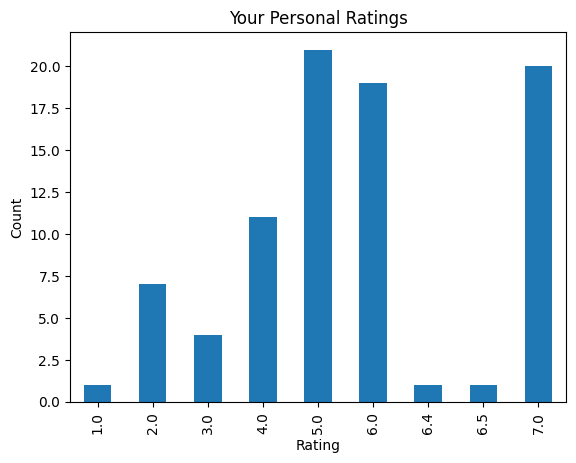

In [31]:
combined_data.info()
combined_data.head()
combined_data[features].head()


# Rating distribution
combined_data['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Your Personal Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [32]:
print(combined_data.columns)
print(combined_data['rating'].head(20))
print(combined_data['rating'].notnull().sum())


Index(['ID', 'title', 'release_year', 'age', 'Rotten Tomatoes',
       'netflix_available', 'Hulu', 'prime_available', 'Disney+', 'type',
       'platform', 'Certificate', 'listed_in', 'Overview', 'Runtime',
       'platform_rating', 'No.of.Ratings', 'title_lower', 'Director', 'Actor',
       'PeopleVote', 'Hero_Rating', 'movie_rating', 'content_rating',
       'platform_Disney+', 'platform_Netflix', 'platform_Prime Video',
       'platform_Tamil OTT', 'platform_Telugu OTT', 'rating'],
      dtype='object')
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
Name: rating, dtype: float64
85


In [33]:
# Train-test split (keep random_state if you want reproducibility)
X = combined_data.dropna(subset=features + ['rating'])[features]
y = combined_data.dropna(subset=features + ['rating'])['rating']


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [35]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
import joblib
joblib.dump(model, 'model.pkl')


['model.pkl']

In [36]:
predictions = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, predictions))
print("R² Score:", r2_score(y_test, predictions))


MSE: 3.3192372314195433
R² Score: -0.40911014541395696


In [37]:
unrated = combined_data[combined_data['rating'].isnull()].copy()
unrated_X = unrated[features]

unrated['predicted_rating'] = model.predict(unrated_X)
combined_data.loc[unrated.index, 'predicted_rating'] = unrated['predicted_rating']
# Top 10 recommendations
recommendations = unrated.sort_values(by='predicted_rating', ascending=False)
recommendations[['title', 'platform', 'predicted_rating']].head(10)


,title,platform,predicted_rating
10135,Mankatha,Tamil OTT,6.620175
8859,Kanche,Telugu OTT,6.616667
10219,Ammani,Tamil OTT,6.608667
8869,Arundhati,Telugu OTT,6.601833
9795,Nachavule,Telugu OTT,6.601833
8804,Arya,Telugu OTT,6.600000
8927,Anand,Telugu OTT,6.600000
8907,7/G Rainbow Colony,Telugu OTT,6.600000
9889,Love Today,Telugu OTT,6.600000
9283,Kalloori,Telugu OTT,6.589917


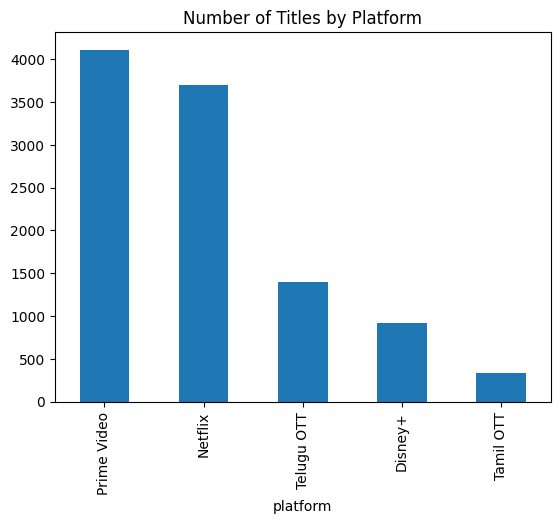

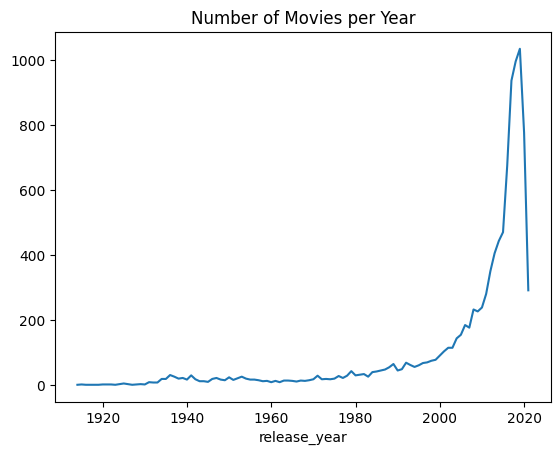

In [38]:
combined_data['platform'].value_counts().plot(kind='bar')
plt.title('Number of Titles by Platform')
plt.show()

combined_data['release_year'].value_counts().sort_index().plot(kind='line')
plt.title('Number of Movies per Year')
plt.show()


In [39]:
combined_data.to_csv('merged_ott_data_final.csv', index=False)


In [40]:
recommend_by_rating_and_platform(unrated, 6.5, tolerance=0.3, platforms=['Netflix'], n=5)


,title,platform,predicted_rating
3263,Twins Mission,Netflix,6.515
236,Like Stars on Earth,Netflix,6.515
168,Stardust,Netflix,6.515
265,Just Another Love Story,Netflix,6.515
789,Naruto Shippuden the Movie,Netflix,6.515


In [41]:
recommend_by_rating_and_platform(unrated,5, tolerance=0.5, platforms=['Telugu OTT', 'Netflix'], n=10)


,title,platform,predicted_rating
8808,OK Kanmani,Telugu OTT,5.495000
8789,Temper,Telugu OTT,5.495000
8917,Rx 100,Telugu OTT,5.493333
9261,Hushaaru,Telugu OTT,5.493333
9183,Neevevaro,Telugu OTT,5.493333
9297,Nannu Dochukunduvate,Telugu OTT,5.493333
9651,All the Best,Telugu OTT,5.478333
9218,Subramanyam for Sale,Telugu OTT,5.470000
9129,Jayasurya,Telugu OTT,5.470000
8837,Masss,Telugu OTT,5.470000


In [42]:
unrated.groupby('platform')['predicted_rating'].mean()

platform
Disney+        5.888770
Netflix        5.454161
Prime Video    5.839307
Tamil OTT      5.043188
Telugu OTT     5.222205
Name: predicted_rating, dtype: float64

In [43]:
my_ratings['platform'].value_counts()

platform
Telugu OTT     83
Netflix        71
Tamil OTT       7
Disney+         1
Prime Video     1
Name: count, dtype: int64

In [44]:
combined_data['platform'].value_counts()
combined_data[combined_data['rating'].notnull()]['platform'].value_counts()

platform
Telugu OTT    69
Netflix       12
Tamil OTT      4
Name: count, dtype: int64